## 机器学习第二次实验 回归模型

- 姓名：管昀玫
- 学号：2013750
- 专业：计算机科学与技术

- 回归是监督学习的一个重要问题，回归用于预测输入变量和输出变量之间的关系，特别是当输入变量的值发生变化时，输出变量的值也随之发生变化。
- 回归模型是一种表示从输入变量到输出变量之间映射的函数
- 对连续值的预测
- 可以用合适的曲线揭示样本点随着自变量的变化关系

### 基本要求
将数据集winequality-white.csv按照4:1划分为训练集和测试集。

1. 构造线性回归模型，并采用批量梯度下降和随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。
2. 对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

特别需要注意：

- 划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。
- 需要对数据集进行一定的预处理

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("winequality-white.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
# 中心化代码
def Normalization_fun(x):
    # 特征零均值
    x = (x - np.mean(x, 0)) / (np.max(x, 0) - np.min(x, 0))
    return x

In [4]:
def StratifiedSampling(df):
    df = df.sort_values(by="quality", ascending=True)

    # 将df根据quality进行分片
    df_layers = []
    for i in df["quality"].unique():
        df_layers.append(df[df["quality"] == i])
    train_index = []
    test_index = []

    # 按分片遍历
    for i in df_layers:
        test_use_list = []  # 新建一个list用于存储random结果
        while len(test_use_list) < int(len(i) / 5):  # 20%进测试集，80%进训练集
            test_use_list.append(np.random.randint(0, len(i)))  # 随机生成分片内的索引

        for ii in range(len(i)):  # 遍历分片内的索引
            if ii not in test_use_list:  # 如果索引不在测试集random索引中
                train_index.append(i.index[ii])  # 将索引加入训练集索引
            else:  # 否则加入测试集索引
                test_index.append(i.index[ii])
    # 将index索引转换为frame
    data = Normalization_fun(df.iloc[:, 0:-1])
    X_train = data.iloc[train_index, : ]
    Y_train = df.iloc[train_index, -1]
    X_test = data.iloc[test_index, : ]
    Y_test = df.iloc[test_index, -1]
    return X_train, Y_train, X_test, Y_test

In [5]:
def predict(alpha, beta, x):
    arr = alpha * x
    return np.sum(arr) + beta

In [6]:
def gradient_descent(x, y, alpha, beta, learn_rate):# 批量梯度下降
    # gradient_arr是整个 alpha 偏导数数组
    gradient_arr = np.zeros((1, x.shape[1]))
    gradient_beta = 0
    mean_s_err = 0
    for line in range(x.shape[0]):
        xline = x.iloc[line, :]
        yline = y.iloc[line]
        # err = y - (alpha X + beta)
        err = yline - predict(alpha, beta, xline)
        # print(gradient_arr,"\n", xline)
        gradient_arr += err * xline.values
        gradient_beta += err
        mean_s_err += err ** 2

    # arr 是 alpha vector的梯度vec， alpha0 是 arr[0]
    gradient_arr = gradient_arr * 2 / x.shape[0]
    gradient_beta = gradient_beta * 2 / x.shape[0]
    mean_s_err /= x.shape[0]
    
    alpha += np.reshape(gradient_arr, alpha.shape) * learn_rate
    beta += gradient_beta * learn_rate
    return alpha, beta, mean_s_err


In [7]:
def gradient_descent_random(x, y, alpha, beta, learn_rate): # 随机梯度下降
    randomId = int(np.random.random_sample() * x.shape[0])
    x = x.iloc[randomId, :]
    y = y.iloc[randomId]
    gradient_arr = np.zeros(x.shape[0])
    gradient_beta = 0
    err = y - predict(alpha, beta, x)
    gradient_arr += err * x
    gradient_beta += err

    # arr 是 alpha vector的梯度vec， alpha0 是 arr[0]
    gradient_arr = gradient_arr * 2
    gradient_beta = gradient_beta * 2

    alpha += np.reshape(gradient_arr, alpha.shape) * learn_rate
    beta += gradient_beta * learn_rate

    return alpha, beta

In [8]:
# 岭回归
def gradient_descent_random_L2(x, y, alpha, beta, learn_rate, L2_lambda):
    randomId = int(np.random.random_sample() * x.shape[0])
    x = x.iloc[randomId, :]
    y = y.iloc[randomId]
    gradient_arr = np.zeros(x.shape[0])
    gradient_beta = 0
    err = y - predict(alpha, beta, x)
    gradient_arr += err * x
    gradient_arr -= alpha * L2_lambda
    gradient_beta += err

    # arr 是 alpha vector的梯度vec， alpha0 是 arr[0]
    gradient_arr = gradient_arr * 2
    gradient_beta = gradient_beta * 2

    alpha += np.reshape(gradient_arr, alpha.shape) * learn_rate
    beta += gradient_beta * learn_rate

    return alpha, beta

In [9]:
def train_model(x, y, learn_rate, loop_times, method):
    # random init alpha, beta
    alpha = np.random.random_sample(x.shape[1])
    beta = np.random.random_sample()
    mean_s_err = 0
    if method == "SGD":
        for i in range(loop_times):
            alpha, beta = gradient_descent_random(x, y, alpha, beta, learn_rate)
        return alpha, beta
    elif method == "SGD_L2":
        for i in range(loop_times):# 试试L2_lambda设置为3e-3 or 0.001 or 0.01
            alpha, beta = gradient_descent_random_L2(x, y, alpha, beta, learn_rate, 1)
        return alpha, beta
    else:
        for i in range(loop_times):
            alpha, beta, mean_s_err = gradient_descent(x, y, alpha, beta, learn_rate)
        return alpha, beta, mean_s_err

In [16]:
'''
flag = ["quality"]
x=data.loc[:, ~data.columns.isin(flag)].copy()
x = Normalization_fun(x)
y= data[flag].copy()
skf =StratifiedShuffleSplit(n_splits=5,test_size=0.25,train_size=0.75,random_state=10)
for train_index, test_index in skf.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
''' 

TRAIN: [4790 1658 4645 ... 4493 3998 4195] TEST: [1759 3737 2576 ... 4296 1741  193]
TRAIN: [ 825 2555 3436 ... 2779 4890 1962] TEST: [1727 3214 1606 ... 2251 1178 4210]
TRAIN: [1771 4695 2817 ... 2973 2595 4883] TEST: [2644 3421  959 ...  466  109 3181]
TRAIN: [1004 2968 1633 ... 4248  762 3828] TEST: [1173  594  755 ... 1110  687 2997]
TRAIN: [4194 2375 4593 ...  265 3832  413] TEST: [2711  780 2042 ... 4050 2915 2497]


5.538509677639809 4.959629287255401 4.957454864374464 4.815874422475323 4.707199203791742 4.882174141712975 5.098106122324515 4.625782144377061 4.695478445510453 4.923525801930998 

learning_rate = 0.001 	 5.538509677639809 4.959629287255401 4.957454864374464 4.815874422475323 4.707199203791742 4.882174141712975 5.098106122324515 4.625782144377061 4.695478445510453 4.923525801930998 

5.033526218723557 4.080575683454252 3.3888003045172947 2.956657858304112 2.5150143778316965 2.0196230177692613 1.7274822452473844 1.546363545617855 1.2910610381462 1.1610566608562238 

learning_rate = 0.01 	 5.033526218723557 4.080575683454252 3.3888003045172947 2.956657858304112 2.5150143778316965 2.0196230177692613 1.7274822452473844 1.546363545617855 1.2910610381462 1.1610566608562238 

2.4004189242118996 0.9134518572540091 0.8458976553165981 0.8745763413069756 0.8288780271568708 0.8366335174806813 0.8340231564782321 0.8336448151765826 0.8366371334978718 0.8212142825823594 

learning_rate = 0.1 	 2.400

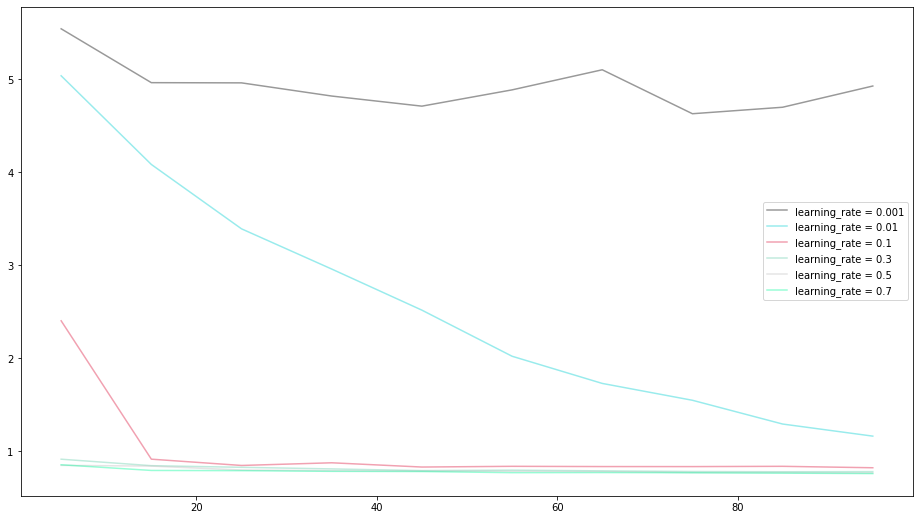

In [10]:
# BGD批量梯度下降
learn_rate = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
mean_s_err_vec_dict = {}
x_loop = [i for i in range(5, 100, 10)]  # 迭代次数
MSE = []

X_train, Y_train, X_test, Y_test = StratifiedSampling(df)
def function(rate):
    mean_s_err = 0
    mean_s_err_vec = []
    for loop in x_loop:
        alpha, beta, mean_s_err = train_model(X_train, Y_train, rate, loop, "BGD")
        mean_s_err_vec.append(np.sqrt(mean_s_err))
    return mean_s_err_vec

for rate in learn_rate:
    mean_s_err_vec_dict[f'learning_rate = {rate}'] = function(rate)

colors = ['#000000', '#00CED1', '#DC143C', '#66CDAA', '#BEBEBE', '#00FA9A','#FF00FF']
points = np.pi * 0.6 ** 2

fig, ax = plt.subplots(figsize=(16, 9))
i = 0
for k, v in mean_s_err_vec_dict.items():
    print(*v,"\n")
    # plt.scatter(x_loop, v, s=points, alpha=0.4, c=colors[i], label=k)
    print(k,"\t",*v,"\n")
    ax.plot(x_loop, v, alpha=0.4, c=colors[i], label=k)
    i += 1
plt.legend()
# plt.show()

#### 结论
通过实验数据可知，学习率过高或过低时都会影响模型准确率。学习率过高会导致过拟合，过低会导致欠拟合。而且，随着loop次数的增加，MSE在稳步下降。由图可知，对于批量梯度下降来说，最佳学习率大约为0.3~0.7之间，它们的MSE的差异随着loop次数的增加逐渐减小，以致基本相同。

learning_rate = 0.001 	 5.338203211505956 5.0265912807652935 5.355223609767796 5.122842419743947 4.779781934826513 5.334725036265477 4.792622392594266 4.808853150835543 4.495431968509427 4.410351321608804 

learning_rate = 0.01 	 5.033596625917952 4.09101513250736 3.2903488806110794 2.9555304143355894 2.3535086591809975 1.9523834897521122 1.7020294398971243 1.3814790018948169 1.4300773138087373 1.2780520525522252 

learning_rate = 0.1 	 2.3636219239123375 1.025995172307876 0.8834647071527226 0.8420556590230688 0.9162468525630373 0.8367372258121193 0.7996594751454207 0.8491529373690629 0.9628376034865614 0.8482775725239529 

learning_rate = 0.3 	 0.9018863907454857 0.8883159646138916 0.8357219604180539 1.165491408776547 0.9001775443749306 0.835717516523939 0.9520796791620731 0.8747218731594845 0.7785741676241292 0.9230583406441516 

learning_rate = 0.5 	 1.4135922249992836 1.405501269769815 0.9091415532840411 1.4037562887034716 2.0763483459327023 1.0020070153583296 0.9084587527762953 1.

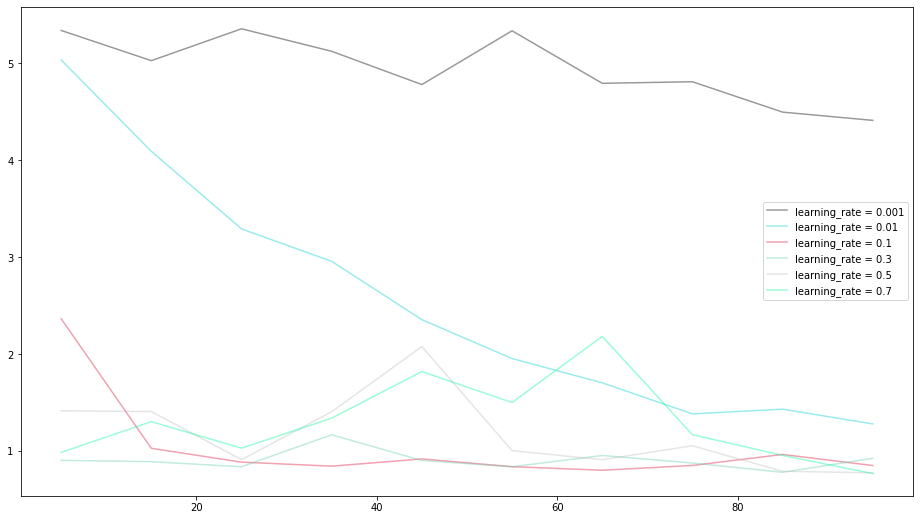

In [11]:
# SGD随机梯度下降
learn_rate = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
mean_s_err_vec_dict = {}
x_loop = [i for i in range(5, 100, 10)]  # 迭代次数

X_train, Y_train, X_test, Y_test = StratifiedSampling(df)
def function(rate):
    mean_s_err = 0
    mean_s_err_vec = []
    for loop in x_loop:
        alpha, beta = train_model(X_train, Y_train, rate, loop, "SGD")
        for i in range(X_test.shape[0]):
            err = Y_test.iloc[i] - predict(alpha, beta, X_test.iloc[i, :])
            mean_s_err += err ** 2
        mean_s_err /= X_test.shape[0]
        mean_s_err_vec.append(np.sqrt(mean_s_err))
    return mean_s_err_vec

for rate in learn_rate:
    mean_s_err_vec_dict[f'learning_rate = {rate}'] = function(rate)

colors = ['#000000', '#00CED1', '#DC143C', '#66CDAA', '#BEBEBE', '#00FA9A','#FF00FF']
points = np.pi * 0.6 ** 2

fig, ax = plt.subplots(figsize=(16, 9))
i = 0
for k, v in mean_s_err_vec_dict.items():
    # plt.scatter(x_loop, v, s=points, alpha=0.4, c=colors[i], label=k)
    print(k,"\t",*v,"\n")
    ax.plot(x_loop, v, alpha=0.4, c=colors[i], label=k)
    i += 1
plt.legend()
# plt.show()

#### 结论
对于随机梯度下降来说，最佳学习率在0.1~0.3之间，且随着loop次数的增加MSE差异逐渐变小。

## 中级要求
探究回归模型在机器学习和统计学上的差异。

### 回归模型在机器学习和统计学上的差异

机器学习和统计学之间的主要区别在于它们的目的：**机器学习模型旨在使最准确的预测成为可能；统计模型被设计用于推断变量之间的关系。**

#### 1. 统计学模型与机器学习在线性回归上的差异

线性回归是一种统计方法，我们训练线性回归量并获得与统计回归模型相同的结果，旨在最小化数据点之间的平方误差。

在机器学习中，我们做了“训练”模型的事情，其中涉及使用数据的一个子集。我们不知道模型将如何执行，直到在训练期间能够“测试”出此数据不存在的、被称为测试集的其他数据。在这种情况下，机器学习的目的是在测试集上获得最佳性能。

对于统计模型，我们只要找出可以最小化所有数据的均方误差（假设数据是一个线性回归量，加上一些随机噪声，本质上通常是高斯噪声），无需训练，也无需测试。

一般来说，特别是在研究中，模型的要点是表征数据与结果变量之间的关系，而不是对未来数据进行预测。我们将此过程称为统计推断，而不是预测。但我们仍然可以使用此模型进行预测，但评估模型的方式不涉及测试集，而是涉及评估模型参数的重要性和稳健性。

（受监督的）机器学习的目的是获得可以进行可重复预测的模型。我们通常不关心模型是否可解释，机器学习只看重结果。而统计建模更多的是发现变量之间的关系和这些关系的重要性，同时也适合预测。

#### 2. 机器学习是基于统计学的

机器学习建立在统计框架之上。统计学的理论是机器学习的统计基础。

统计学与机器学习之间的主要区别在于统计学仅基于概率空间。从集合论中推导出整个统计数据，它讨论了我们如何将数字组合成类别，称为集合，然后对此集合强加一个度量，以确保所有这些的总和值为1，我们称之为概率空间。

除了这些集合和度量的概念之外，统计数据不对宇宙做任何其他假设。这就是为什么当我们用非常严格的数学术语指定概率空间时，我们指定了3个东西。

概率空间，我们这样表示，（Ω，F，P）由三部分组成：

- 样本空间Ω，它是所有可能结果的集合

- 一组事件F，其中每个事件是包含零个或多个结果的集合

- 为事件分配概率P; 也就是说，从事件到概率的函数

根据监督学习的统计学习理论，一组数据，我们将其表示为S={(xᵢ，yᵢ)}。这是一个有n个数据点的数据集，每个数据点由我们称之为功能的其他一些值描述，这些值由x提供，并且这些特征由某个函数映射以给出值y。

假如说我们已经有了这些数据，我们的目标是找到将x值映射到y值的函数。可以描述此映射的所有可能函数的集合，称为假设空间。

要找到这个函数，我们必须让算法“学会”一些方法来找出解决问题的最佳方法，这个过程由损失函数实现。因此，对于我们所拥有的每个假设（建议函数），需要通过查看其对所有数据的预期风险值来评估该函数的执行情况。

预期风险基本上是损失函数乘以数据概率分布的总和。如果我们知道映射的联合概率分布，就很容易找到最佳函数。然而，这通常是未知的，因此我们最好的选择是猜测，然后凭经验确定损失函数是否更好。我们称之为经验风险。

然后，我们可以比较不同的函数，并寻找给出最小预期风险的假设，即假设给出数据上所有假设的最小值（称为下限）。

然而，该算法具有作弊的倾向，可以通过过度拟合数据来最小化其损失函数。这就是为什么在学习基于训练集数据的函数之后，该函数需要在测试数据集上进行验证，验证用的数据数据不会出现在训练集中。

显然，这不是统计学看重的点，因为统计学并不需要最小化经验风险。选择最小化经验风险的函数的学习算法称为经验风险最小化。

## 高级要求

编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法均可）。

In [10]:

# 岭回归 这个函数前面写了，这里不需要跑
def gradient_descent_random_L2(x, y, alpha, beta, learn_rate, L2_lambda):
    L2_lambda = 0.01
    randomId = int(np.random.random_sample() * x.shape[0])
    x = x.iloc[randomId, :]
    y = y.iloc[randomId]
    gradient_arr = np.zeros(x.shape[0])
    gradient_beta = 0
    err = y - predict(alpha, beta, x)
    gradient_arr += err * x
    gradient_arr -= alpha * L2_lambda# 加上L2 penalty
    gradient_beta += err

    # arr 是 alpha vector的梯度vec， alpha0 是 arr[0]
    gradient_arr = gradient_arr * 2
    gradient_beta = gradient_beta * 2

    alpha += np.reshape(gradient_arr, alpha.shape) * learn_rate
    beta += gradient_beta * learn_rate

    return alpha, beta


learning_rate = 0.001 	 5.347935317429053 5.428510573071651 5.1355604372759265 5.021323222609492 5.396573539225938 5.321552503238591 5.02396503664282 4.786568944768707 4.249845478377553 4.428925330153538 4.438365537106184 4.513700794539037 4.655898679567757 3.9961301684076447 4.394958601431716 4.016794745340161 4.069404120561908 4.196321790035234 3.647767032965497 3.685861169005132 3.527672635439909 3.470439356073356 3.4848722473461597 3.508412004686848 3.6820917272962332 3.5722371352881237 3.2443776773613666 3.200175330514277 3.147559322151068 3.0264213045317905 2.8862457580495424 2.867445922483717 2.972049987056205 2.76765898025732 2.6830127723191652 2.626865882140729 2.8286084396588866 2.620374723348787 2.8263575369382004 2.72215700900782 2.57013138825014 2.6063582806871874 2.2372434530566343 2.6052036503547678 2.318027138361738 2.334517258271131 2.2507471269602872 2.284924657942203 2.154060137590521 2.2096987154399526 2.2642957286278724 2.180805494350848 2.0491823864543486 2.038058

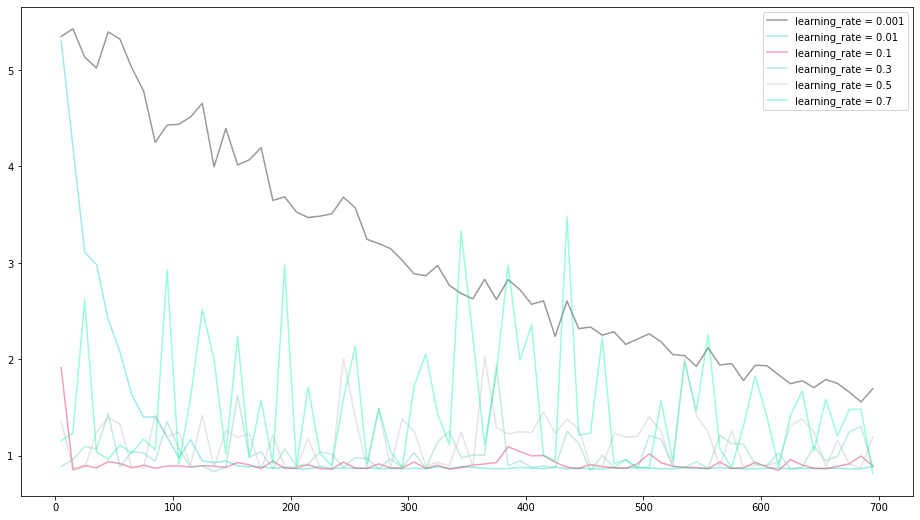

In [13]:
# 岭回归 随机梯度下降 L2_lambda = 1
learn_rate = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
mean_s_err_vec_dict = {}
x_loop = [i for i in range(5, 700, 10)]  # 迭代次数

X_train, Y_train, X_test, Y_test = StratifiedSampling(df)
def function(rate):
    mean_s_err = 0
    mean_s_err_vec = []
    for loop in x_loop:
        alpha, beta = train_model(X_train, Y_train, rate, loop, "SGD_L2")
        for i in range(X_test.shape[0]):
            err = Y_test.iloc[i] - predict(alpha, beta, X_test.iloc[i, :])
            mean_s_err += err ** 2
        mean_s_err /= X_test.shape[0]
        mean_s_err_vec.append(np.sqrt(mean_s_err))
    return mean_s_err_vec

for rate in learn_rate:
    mean_s_err_vec_dict[f'learning_rate = {rate}'] = function(rate)

colors = ['#000000', '#00CED1', '#DC143C', '#66CDAA', '#BEBEBE', '#00FA9A','#FF00FF']
points = np.pi * 0.6 ** 2

fig, ax = plt.subplots(figsize=(16, 9))
i = 0
for k, v in mean_s_err_vec_dict.items():
    # plt.scatter(x_loop, v, s=points, alpha=0.4, c=colors[i], label=k)
    print(k,"\t",*v,"\n")
    ax.plot(x_loop, v, alpha=0.4, c=colors[i], label=k)
    i += 1
plt.legend()
# plt.show()

learning_rate = 0.001 	 5.742970673613277 5.599493247548835 5.463107896216411 4.663244596857244 5.194664966173732 4.683787775239729 4.985276271441249 5.008163843511597 4.796738767327236 4.284303144791928 4.283538794447952 4.247381125647713 4.213678861463233 3.9166538624265455 3.8803705489114653 3.9099211313790323 3.763255976503751 4.060323551471607 4.09346967972256 3.728596147491654 3.9515384693956954 3.2933547099627387 3.7099243811807927 3.379726978058118 3.526616551506736 3.555061380598461 3.094819951614923 3.160469105516166 3.060929190008779 3.2716662196098243 3.218825580761119 2.858483196661214 3.139983994819742 2.8828038481511964 2.77826984988479 2.580704822122552 2.644079817502028 2.8165256105006207 2.5804470913472115 2.679919882787074 2.3906315360721604 2.621664313017973 2.311958403497999 2.2928029341272906 2.177628699022051 2.3452970682661336 2.3511574591942748 2.2790723133450532 2.3631473357204666 2.1378992572156656 2.2695828717797677 2.1413416663149225 2.2009126742659473 1.86

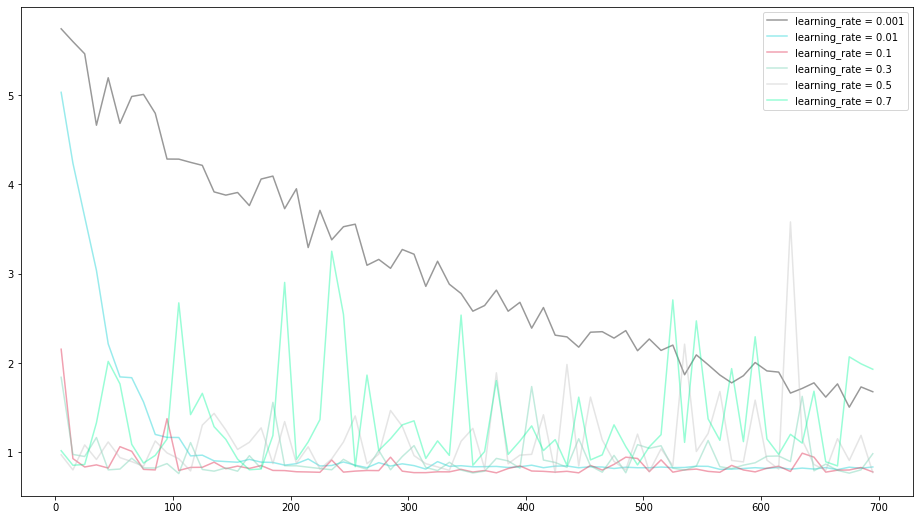

In [11]:
# 岭回归 随机梯度下降 L2_lambda = 0.01
learn_rate = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
mean_s_err_vec_dict = {}
x_loop = [i for i in range(5, 700, 10)]  # 迭代次数

X_train, Y_train, X_test, Y_test = StratifiedSampling(df)
def function(rate):
    mean_s_err = 0
    mean_s_err_vec = []
    for loop in x_loop:
        alpha, beta = train_model(X_train, Y_train, rate, loop, "SGD_L2")
        for i in range(X_test.shape[0]):
            err = Y_test.iloc[i] - predict(alpha, beta, X_test.iloc[i, :])
            mean_s_err += err ** 2
        mean_s_err /= X_test.shape[0]
        mean_s_err_vec.append(np.sqrt(mean_s_err))
    return mean_s_err_vec

for rate in learn_rate:
    mean_s_err_vec_dict[f'learning_rate = {rate}'] = function(rate)

colors = ['#000000', '#00CED1', '#DC143C', '#66CDAA', '#BEBEBE', '#00FA9A','#FF00FF']
points = np.pi * 0.6 ** 2

fig, ax = plt.subplots(figsize=(16, 9))
i = 0
for k, v in mean_s_err_vec_dict.items():
    # plt.scatter(x_loop, v, s=points, alpha=0.4, c=colors[i], label=k)
    print(k,"\t",*v,"\n")
    ax.plot(x_loop, v, alpha=0.4, c=colors[i], label=k)
    i += 1
plt.legend()
# plt.show()

#### 结论
由于loop次数设置为100时各个learning_rate的MSE都还不够稳定，因此将loop次数调高至700。由图可知，对于岭回归，最佳学习率为0.3。